In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from matplotlib import pyplot as plt
import os
import json

plt.style.use('seaborn-deep')


In [2]:
full_df = pd.read_pickle('/data/newhouse/LRT/batch/master/training/tracks_weighted.pkl')

In [3]:
inputs_names = [ 
"z0",
"d0",
"numberOfSCTHits",
"Sihits",
"eta",
"numberDoF",
"geometric_var",
"numberOfSCTHoles",
]
label_names = ["is_good"]

df_unscaled = full_df[inputs_names + label_names]
df_unscaled

,z0,d0,numberOfSCTHits,Sihits,eta,numberDoF,geometric_var,numberOfSCTHoles,is_good
2436564,-52.148543,5.186578,8.0,11.0,-0.186277,9.0,1.286456,0.0,True
2095452,-19.248379,-13.718926,8.0,9.0,-0.831585,5.0,0.202004,0.0,True
2662575,172.962090,-43.974552,8.0,10.0,0.814237,7.0,0.585028,0.0,True
2100967,11.981685,-24.358263,10.0,11.0,-2.067754,7.0,1.776335,0.0,True
2534252,37.727240,-5.855665,9.0,12.0,1.378940,10.0,0.339448,0.0,True
...,...,...,...,...,...,...,...,...,...
1347462,120.408718,-15.788794,8.0,9.0,1.358097,5.0,0.373010,1.0,False
285675,-311.817440,60.555431,7.0,8.0,-1.953836,4.0,0.089769,0.0,False
1452710,-99.811858,-30.255880,7.0,8.0,-2.071283,4.0,0.043599,1.0,False
845497,418.289387,-5.668040,8.0,11.0,-2.514737,9.0,2.966626,1.0,False


In [4]:
# Now we'll scale the dataframe to make the network train more effectively
# The shift and scale can be saved in the lwtnn config and is evaluated at runtime
scaler = StandardScaler() # make the scaler
scaler.fit(df_unscaled[inputs_names]) # fit the scaler to the data
df = pd.DataFrame(scaler.transform(df_unscaled[inputs_names]),
                  columns=inputs_names,
                  index=df_unscaled.index) # create a new dataframe with the same index
df['is_good'] = df_unscaled['is_good'] # add the labels back in (unscaled)
print('mean:', scaler.mean_)
print('scale:', 1/scaler.scale_)
df

mean: [ 0.56498952 -2.60922267  7.91519942  9.04650053  0.01326204  5.17780165
  1.1861707   0.26606773]
scale: [0.00488547 0.01289326 0.93464623 0.67824859 0.74485824 0.41405728
 1.11847908 2.26295494]


,z0,d0,numberOfSCTHits,Sihits,eta,numberDoF,geometric_var,numberOfSCTHoles,is_good
2436564,-0.257530,0.100513,0.079259,1.324958,-0.148628,1.582609,0.112167,-0.602099,True
2095452,-0.096798,-0.143240,0.079259,-0.031539,-0.629291,-0.073620,-1.100770,-0.602099,True
2662575,0.842241,-0.533334,0.079259,0.646710,0.596613,0.754494,-0.672365,-0.602099,True
2100967,0.055776,-0.280416,1.948551,1.324958,-1.550062,0.754494,0.660086,-0.602099,True
2534252,0.181555,-0.041857,1.013905,2.003207,1.017236,1.996666,-0.947042,-0.602099,True
...,...,...,...,...,...,...,...,...,...
1347462,0.585493,-0.169928,0.079259,-0.031539,1.001711,-0.073620,-0.909503,1.660856,False
285675,-1.526135,0.814398,-0.855388,-0.709788,-1.465209,-0.487677,-1.226302,-0.602099,False
1452710,-0.490388,-0.356456,-0.855388,-0.709788,-1.552691,-0.487677,-1.277943,1.660856,False
845497,2.040780,-0.039438,0.079259,1.324958,-1.883001,1.582609,1.991402,1.660856,False


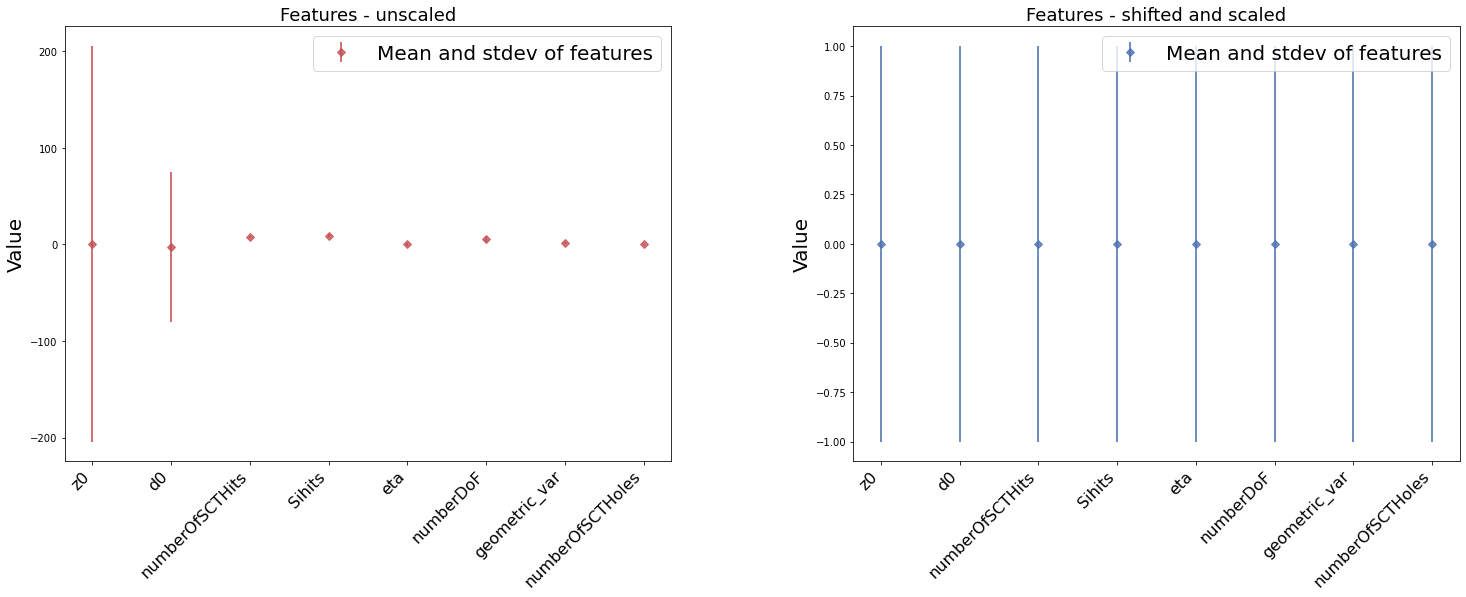

In [55]:
# Plot features
labels = inputs_names
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,8))
ax1.plot(labels, scaler.mean_, alpha=0, label='Track')
unscaled = ax1.errorbar(labels, scaler.mean_, yerr=scaler.scale_, fmt='D', color='#C44E52', ecolor='#C44E52', linewidth=2, alpha = 0.8, label='_nolegend_')
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=16,)
ax1.legend([unscaled],["Mean and stdev of features"], fontsize=20)
ax1.set_title("Features - unscaled", fontsize=18)
ax1.set_ylabel("Value", fontsize=20)

ax2.plot(labels, scaler.mean_-scaler.mean_, alpha=0, label='Track')
scaled = ax2.errorbar(labels, scaler.mean_-scaler.mean_, yerr=scaler.scale_/scaler.scale_, fmt='D', color='#4C72B0', ecolor='#4C72B0', linewidth=2, alpha = 0.8, label='_nolegend_')
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=16,)
ax2.legend([scaled],["Mean and stdev of features"], fontsize=20)
ax2.set_title("Features - shifted and scaled", fontsize=18)
ax2.set_ylabel("Value", fontsize=20)

plt.subplots_adjust(wspace = 0.3)

In [34]:
# split into training and validation sets
train, test = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)

Model: "r3lrt_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 8)]               0         
_________________________________________________________________
dense_0 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
regularizer_1 (Dense)        (None, 64)                1600      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 1)                 

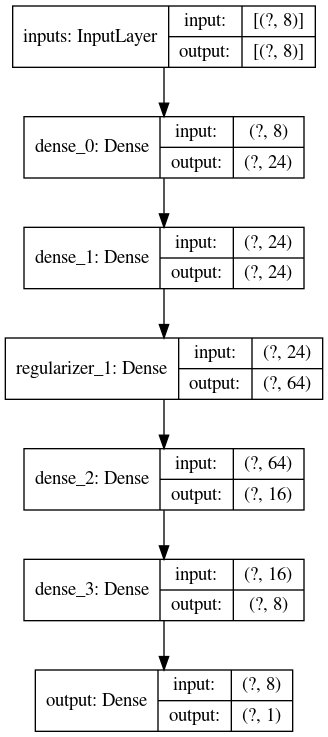

In [35]:
# Create model
def create_model():
    in_len = len(inputs_names)
    # Input layer
    inputs = keras.Input(shape=(in_len), name='inputs')

    # Hidden layers
    # dense = 
    x = layers.Dense(in_len*3, activation="relu", name='dense_0')(inputs)
    x = layers.Dense(in_len*3, activation="relu", name='dense_1')(x)
    x = layers.Dense(units=64, # regularixation layer
                     kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                     bias_regularizer=regularizers.l2(1e-4),
                     activity_regularizer=regularizers.l2(1e-5),
                     name='regularizer_1')(x)
    x = layers.Dense(in_len*2, activation="relu", name='dense_2')(x)
    x = layers.Dense(in_len*1, activation="relu", name='dense_3')(x)
    
    # Output layer
    outputs = layers.Dense(1,  activation="sigmoid", name='output')(x)    
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="r3lrt_model")
    print(model.summary())
    
    return model

model = create_model()
keras.utils.plot_model(model, "r3lrt_model.png", show_shapes=True)

In [36]:
# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer = keras.optimizers.Adamax(lr=0.0003),
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

In [38]:
history = model.fit(train[inputs_names], 
                    train[label_names], 
                    epochs=20, 
                    batch_size=500,
                    validation_data=(test[inputs_names], 
                                     test[label_names]),
                   )

Epoch 1/20
240/240 [==============================] - 2s 8ms/step - loss: 0.3433 - accuracy: 0.8567 - precision: 0.8830 - recall: 0.8233 - val_loss: 0.3307 - val_accuracy: 0.8648 - val_precision: 0.8894 - val_recall: 0.8309
Epoch 2/20
240/240 [==============================] - 3s 11ms/step - loss: 0.3368 - accuracy: 0.8590 - precision: 0.8847 - recall: 0.8264 - val_loss: 0.3254 - val_accuracy: 0.8664 - val_precision: 0.8879 - val_recall: 0.8365
Epoch 3/20
240/240 [==============================] - 3s 13ms/step - loss: 0.3323 - accuracy: 0.8603 - precision: 0.8847 - recall: 0.8293 - val_loss: 0.3217 - val_accuracy: 0.8670 - val_precision: 0.8889 - val_recall: 0.8365
Epoch 4/20
240/240 [==============================] - 3s 13ms/step - loss: 0.3288 - accuracy: 0.8611 - precision: 0.8847 - recall: 0.8312 - val_loss: 0.3186 - val_accuracy: 0.8676 - val_precision: 0.8930 - val_recall: 0.8332
Epoch 5/20
240/240 [==============================] - 4s 16ms/step - loss: 0.3260 - accuracy: 0.8618 

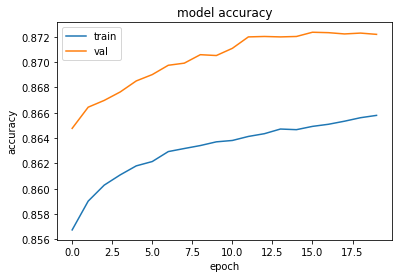

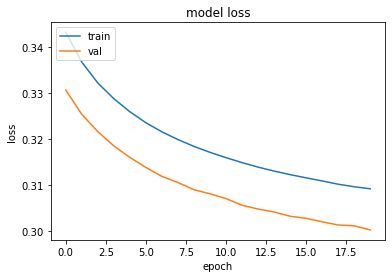

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
# evaluate predictions on validation set
predictions = model.predict(test[inputs_names])

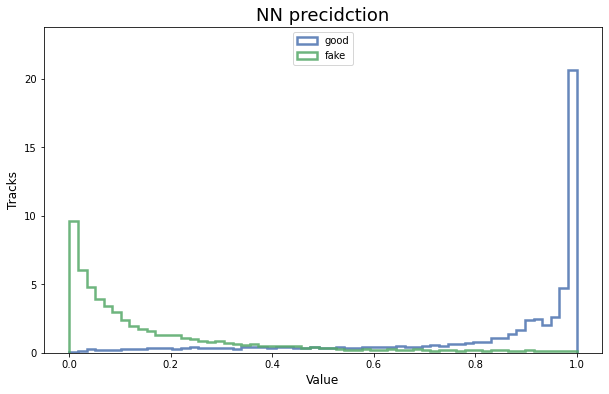

In [41]:
# Visualize the NN dicriminant evaluated on good and fake tracks
pred_good = predictions[test['is_good'] == True]
pred_fake = predictions[test['is_good'] == False]

fig, ax1 = plt.subplots(1, 1,figsize=(10,6))
x = [pred_good, pred_fake]
edgecolors = ['#4C72B0','#55A868']
for i in [0,1]:
    ax1.hist(x[i], edgecolor=edgecolors[i], histtype='step', linewidth=2.5, alpha=0.85, density=1, bins = np.linspace(0,1,60))
ax1.set_xlabel("Value", fontsize=12)
ax1.set_ylabel("Tracks", fontsize=12)
ax1.set_title("NN precidction", fontsize=18)
ax1.legend(['good', 'fake'], loc='upper center')
# ax1.set_yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(ymin,ymax*1.1)
plt.show()
# plt.savefig('{}/discriminant.png'.format(model_dir),)

In [42]:
# There are several metrics that indicate performance
# https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

model_performance = {}
threshold = 0.5
    
model_performance['accuracy_score'] = accuracy_score(y_true=test['is_good'], y_pred=predictions>threshold)
print("Accuracy %.4f" % model_performance['accuracy_score'])
model_performance['f1_score'] = f1_score(y_true=test['is_good'], y_pred=predictions>threshold)
print("F1 Score %.4f" % model_performance['f1_score'])
model_performance['precision_score'] = precision_score(y_true=test['is_good'], y_pred=predictions>threshold)
print("Precision %.4f" % model_performance['precision_score'])
model_performance['recall_score'] = recall_score(y_true=test['is_good'], y_pred=predictions>threshold)
print("Recall %.4f" % model_performance['recall_score'])
model_performance['confusion_matrix'] = confusion_matrix(y_true=test['is_good'], y_pred=predictions>threshold)
print("Confusion Matrix: \n", model_performance['confusion_matrix'])    

Accuracy 0.8722
F1 Score 0.8676
Precision 0.8928
Recall 0.8438
Confusion Matrix: 
 [[13554  1503]
 [ 2318 12522]]


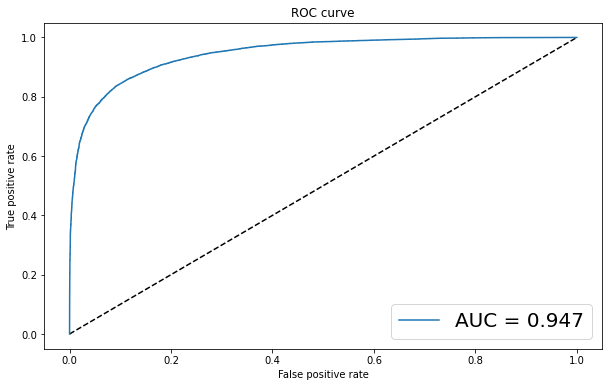

In [43]:
# Plotting the ROC curve
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
y_pred_keras = predictions.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test['is_good'], y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1, (10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best', fontsize=20)
plt.show()
# plt.savefig('{}/roc.png'.format(model_dir),)

In [ ]:
cut_vals = np.linspace(0,.3,50)
signal_acc = []
background_rej = []
for cut_val in cut_vals:
    cut_query = f'predictions > {cut_val}'
    # print(f'cut at nn score of {cut_val}')
    signal_acc.append(len(good.query(cut_query))/len(good))
    background_rej.append(len(fake.query(cut_query))/len(fake))

plt.figure(figsize=(12,8))
plt.plot(cut_vals, signal_acc, linewidth=4,)
plt.plot(cut_vals, background_rej, linewidth=4,)
ax = plt.gca()

# Show the major grid lines with dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('NN score threshold',  fontsize=25)
ax.set_ylabel('Fraction of tracks accepted', fontsize=25)
ax.legend(['good tracks', 'fake tracks'], fontsize=20)


In [44]:
model_dir = '/home/newhouse/tmp/model/'
lwtnn_dir = '/home/newhouse/public/Analysis/LRT/lwtnn/'

# save architecture
arch = model.to_json()
with open(f'{model_dir}architecture.json', 'w') as arch_file:
    arch_file.write(arch)
# now save the weights as an HDF5 file
model.save_weights(f'{model_dir}weights.h5')

# Generate variables file with lwtnn
make_variables_command = f'{lwtnn_dir}converters/kerasfunc2json.py {model_dir}architecture.json {model_dir}weights.h5 > {model_dir}variables.json'
print(make_variables_command)
if os.system(make_variables_command) == 0:
    print('success')
else:
    print('failure')
    

/home/newhouse/public/Analysis/LRT/lwtnn/converters/kerasfunc2json.py /home/newhouse/tmp/model/architecture.json /home/newhouse/tmp/model/weights.h5 > /home/newhouse/tmp/model/variables.json
success


In [51]:
# or manually make the variables file
with open(f'{model_dir}variables.json', 'r') as variables_json:
    inputs_dict = json.load(variables_json)

# update the names to the correct variables
# and aply the correct shift and scale
for i, (item, df_name) in enumerate(zip(inputs_dict['inputs'][0]['variables'], inputs_names)):
    print(item['name'], '->', df_name)
    item['name'] = df_name
    item['offset'] = -scaler.mean_[i]
    item['scale'] = 1/scaler.scale_[i]

# rename the inputs label
print()
print(inputs_dict['inputs'][0]['name'], '->' ,'track_inputs')
inputs_dict['inputs'][0]['name'] = 'track_inputs'

# do the same with the output label
print()
print(inputs_dict['outputs'][0]['labels'][0], '->', 'nn_score')
inputs_dict['outputs'][0]['labels'][0] = 'nn_score'
    
with open(f'{model_dir}variables.json', 'w') as variables_json:
    inputs_dict = json.dump(inputs_dict, variables_json, indent=2 )

z0 -> z0
d0 -> d0
numberOfSCTHits -> numberOfSCTHits
Sihits -> Sihits
eta -> eta
numberDoF -> numberDoF
geometric_var -> geometric_var
numberOfSCTHoles -> numberOfSCTHoles

track_inputs -> track_inputs

nn_score -> nn_score


In [52]:
kerasfunc2json_command = f'{lwtnn_dir}converters/kerasfunc2json.py {model_dir}architecture.json {model_dir}weights.h5 {model_dir}variables.json > {model_dir}nn-config.json'
print(kerasfunc2json_command)
if os.system(kerasfunc2json_command) == 0:
    print('success')
else:
    print('failure')
    

/home/newhouse/public/Analysis/LRT/lwtnn/converters/kerasfunc2json.py /home/newhouse/tmp/model/architecture.json /home/newhouse/tmp/model/weights.h5 /home/newhouse/tmp/model/variables.json > /home/newhouse/tmp/model/nn-config.json
success


In [57]:
# TESTING
import uproot

tested = uproot.open("/home/newhouse/public/Analysis/LRT/LRTProduction/run/15_v7/test_run/track_info_InDetSummaryDumpAlg_R3LargeD0.root")['tracks']
# tested.pandas.df().nnScore.hist()
df = tested.pandas.df()

In [58]:
df.rename({'track_eta': 'eta'}, axis='columns', inplace=True)
df.rename({'geometricVariable': 'geometric_var'}, axis='columns', inplace=True)
df['geometric_var_py'] = abs(np.arctan2(abs(df.d0),df.z0)-2*np.arctan(np.exp(-df.eta)))
# abs values
df['abs_z0'] = abs(df.z0)
df['abs_d0'] = abs(df.d0)
df['abs_eta'] = abs(df.eta)
# silicon hits
df['Sihits'] = df.numberOfPixelHits + df.numberOfSCTHits

Text(0.5, 0, 'nnScore')

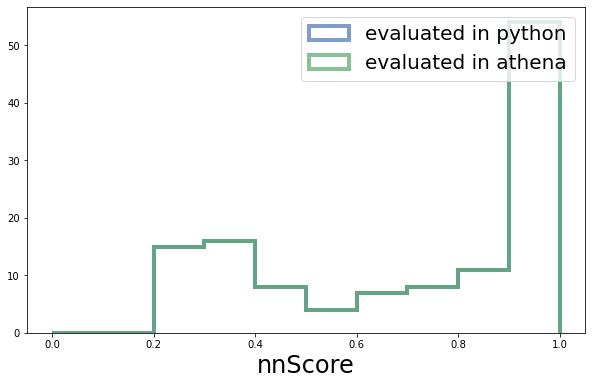

In [63]:
fig = plt.figure(figsize=[10,6])
predictions = model.predict(scaler.transform(df[inputs_names]))
plt.hist(predictions, histtype='step', bins=np.linspace(0,1,11), linewidth=4, alpha=.7)
plt.hist(df.nnScore,  histtype='step', bins=np.linspace(0,1,11), linewidth=4, alpha=.7)
ax = plt.gca()
ax.legend(['evaluated in python', 'evaluated in athena'], fontsize=20)
ax.set_xlabel('nnScore', fontsize=24)